In [1]:
import pandas as pd
from datetime import datetime
import cvxpy as cp
from regimeaware.core import utils
from regimeaware.routines import cfg
# from regimeaware.data.problem_data import *
import numpy as np
from regimeaware.core.opt import min_EVaR_portfolio

# cfg.data_fldr = r"C:\Users\franc\My Drive\bin\regimeaware/data"

rebalance_dts = pd.date_range(start=cfg.bt_start_dt, end=cfg.bt_end_dt, freq=cfg.rebalance_freq)
dt = datetime(2022, 12, 31)
as_of_dt = datetime(2022, 12, 31)

# Tradability flags, Market cap, and Sector mapping
is_tradable = pd.read_pickle(f'{cfg.data_fldr}/is_tradable.pkl')
tradable_ids = is_tradable[is_tradable].xs(dt).index

In [2]:
betas = pd.read_pickle(f'{cfg.data_fldr}/exposures/state_betas.pkl').xs(dt).loc[tradable_ids, ['const'] + cfg.factor_set]
state_means = pd.read_pickle(f'{cfg.data_fldr}/regimes/mu.pkl').xs(as_of_dt)[cfg.factor_set]
state_vcv = pd.read_pickle(f'{cfg.data_fldr}/regimes/sigma.pkl').xs(as_of_dt).loc[pd.IndexSlice[range(cfg.n_states), cfg.factor_set], cfg.factor_set]
emission_prob = pd.read_pickle(f"{cfg.data_fldr}/regimes/emission_prob.pkl").xs(as_of_dt)
transition_matrix = pd.read_pickle(f"{cfg.data_fldr}/regimes/transmat.pkl").xs(as_of_dt)
pi = emission_prob.xs(as_of_dt)[range(cfg.n_states)].values
state_sigma_e = pd.read_pickle(f'{cfg.data_fldr}/exposures/state_resid.pkl').xs(dt)[tradable_ids]

# Opt variables
mu_f = state_means.values
mu_f_const = np.concatenate([np.array([1] * cfg.n_states).reshape(-1, 1), state_means.values], axis=1)
Sigma_f = np.array([state_vcv.xs(s).values for s in range(cfg.n_states)])
Sigma_f_const = np.array([pd.concat([pd.Series(0), state_vcv.xs(s)]).fillna(0).values for s in range(cfg.n_states)])
phi = np.array([betas.xs(s, level=1).values for s in range(cfg.n_states)])

In [56]:
collect_mu = []
collect_sigmas = []
for s in range(cfg.n_states):
    b_s = betas.xs(s, level=1).loc[tradable_ids]

    mu_s = state_means.xs(s)
    mu_s['const'] = 1
    mu_i = b_s.dot(mu_s)
    
    V_i = b_s.drop('const', axis=1).dot(state_vcv.xs(s)).dot(b_s.drop('const', axis=1).T)
    V_i += np.diag(state_sigma_e.xs(s))

    collect_mu += [mu_i[tradable_ids].to_frame(s)]
    collect_sigmas += [V_i.loc[tradable_ids, tradable_ids].values]
    
mus = pd.concat(collect_mu, axis=1).T.values
Sigmas = np.array(collect_sigmas)

0.9999999840502884
0.9999999840502884
non-zero 35


<Axes: >

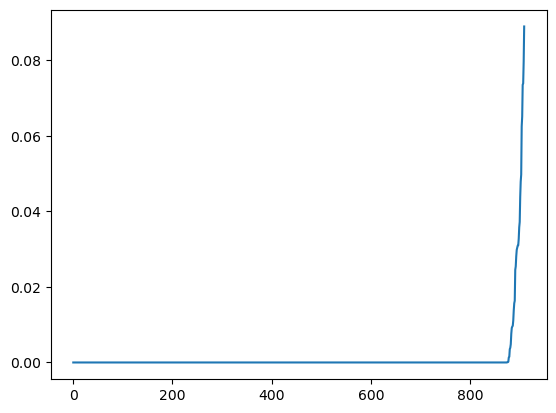

In [4]:
w, delta, prob = min_EVaR_portfolio(alpha=.1, L=2, mus=mus, sigmas=Sigmas, pi=pi)

# print(w)
print(w.sum())
print(np.abs(w).sum())
print("non-zero", len(w) - np.isclose(w.flatten(), 0, atol=5e-5).sum())
pd.Series(w.flatten()).sort_values().reset_index(drop=True).plot()

0.9999999996584156
0.9999999996584156
non-zero 33


<Axes: >

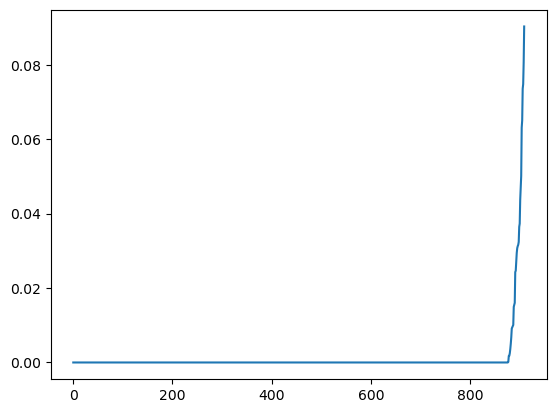

In [71]:
collect_mu = []
collect_sigmas = []
for s in range(cfg.n_states):
    b_s = betas.xs(s, level=1).loc[tradable_ids]

    mu_s = state_means.xs(s)
    mu_s['const'] = 1
    mu_i = b_s.dot(mu_s)
    
    V_i = b_s.drop('const', axis=1).dot(state_vcv.xs(s)).dot(b_s.drop('const', axis=1).T)
    V_i += np.diag(state_sigma_e.xs(s))

    collect_mu += [mu_i[tradable_ids].to_frame(s)]
    collect_sigmas += [V_i.loc[tradable_ids, tradable_ids].values]
    
mus = pd.concat(collect_mu, axis=1).T.values
Sigmas = np.array(collect_sigmas)

import cvxpy as cvx

gamma = 75
n = len(tradable_ids)
k = cfg.n_states

def K(w):
    u = cvx.vstack([cvx.log(pi[i])
      - gamma * mus[i] @ w
      + (gamma**2/2) * cvx.quad_form(w, Sigmas[i]) for i in range(k)])
    return cvx.log_sum_exp(u)

w = cvx.Variable(n)
objective = cvx.Minimize(K(w))
constraints = [ w >= 0, cvx.sum(w) == 1 ]
egm_prob = cvx.Problem(objective, constraints)
egm_prob.solve(solver=cp.MOSEK)


print(w.value.sum())
print(np.abs(w.value).sum())
print("non-zero", len(w.value) - np.isclose(w.value.flatten(), 0, atol=5e-5).sum())
pd.Series(w.value.flatten()).sort_values().reset_index(drop=True).plot()

0.9999999988781092
0.9999999988781092
non-zero 65


<Axes: >

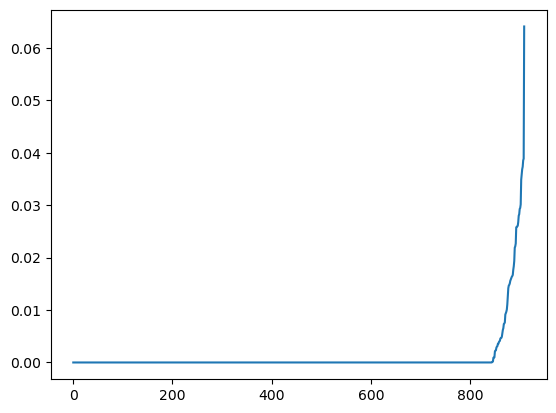

In [77]:
beta = .75

collect_mu = []
collect_sigmas = []
for s in range(cfg.n_states):
    b_s = betas.xs(s, level=1).loc[tradable_ids]

    mu_s = state_means.xs(s)
    mu_s['const'] = 1
    mu_i = b_s.dot(mu_s)
    
    V_i = b_s.drop('const', axis=1).dot(state_vcv.xs(s)).dot(b_s.drop('const', axis=1).T)
    V_i += np.diag(state_sigma_e.xs(s))

    # Shrinkage
    mu_bar = mu_i.mean()
    sigma_bar = np.diag(V_i).mean()

    mu_i = mu_i * beta + (1 - beta) * mu_bar
    V_i = sigma_bar * np.eye(len(tradable_ids)) * (1 - beta) + beta * V_i

    collect_mu += [mu_i[tradable_ids].to_frame(s)]
    collect_sigmas += [V_i.loc[tradable_ids, tradable_ids].values]
    
mus = pd.concat(collect_mu, axis=1).T.values
Sigmas = np.array(collect_sigmas)


gamma = 75
reg_param = 100
n = len(tradable_ids)
k = cfg.n_states

def K(w):
    u = cvx.vstack([cvx.log(pi[i])
      - gamma * mus[i] @ w
      + (gamma**2/2) * cvx.quad_form(w, Sigmas[i]) for i in range(k)])
    return cvx.log_sum_exp(u) #+ reg_param * cvx.sum_squares(w)

w = cvx.Variable(n)
objective = cvx.Minimize(K(w))
constraints = [w >= 0, cvx.sum(w) == 1 ]
egm_prob = cvx.Problem(objective, constraints)
egm_prob.solve(solver=cp.MOSEK)


print(w.value.sum())
print(np.abs(w.value).sum())
print("non-zero", len(w.value) - np.isclose(w.value.flatten(), 0, atol=5e-5).sum())
pd.Series(w.value.flatten()).sort_values().reset_index(drop=True).plot()

In [26]:
n

991

In [27]:
n - np.isclose(w.value, 0).sum()

595